<a href="https://colab.research.google.com/github/dostirathi031/alz_Detection/blob/main/xception_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import os
import pandas as pd

MildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths         labels
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [ ]:
Alzheimer_df.shape

(33984, 2)

In [ ]:
train_images, test_images = train_test_split(
    Alzheimer_df, test_size=0.3, random_state=42, stratify=Alzheimer_df['labels']
)
train_set, val_set = train_test_split(
    train_images, test_size=0.2, random_state=42, stratify=train_images['labels']
)


In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(19030, 2)
(10196, 2)
(4758, 2)
(23788, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 19030 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 4758 validated image filenames belonging to 4 classes.


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

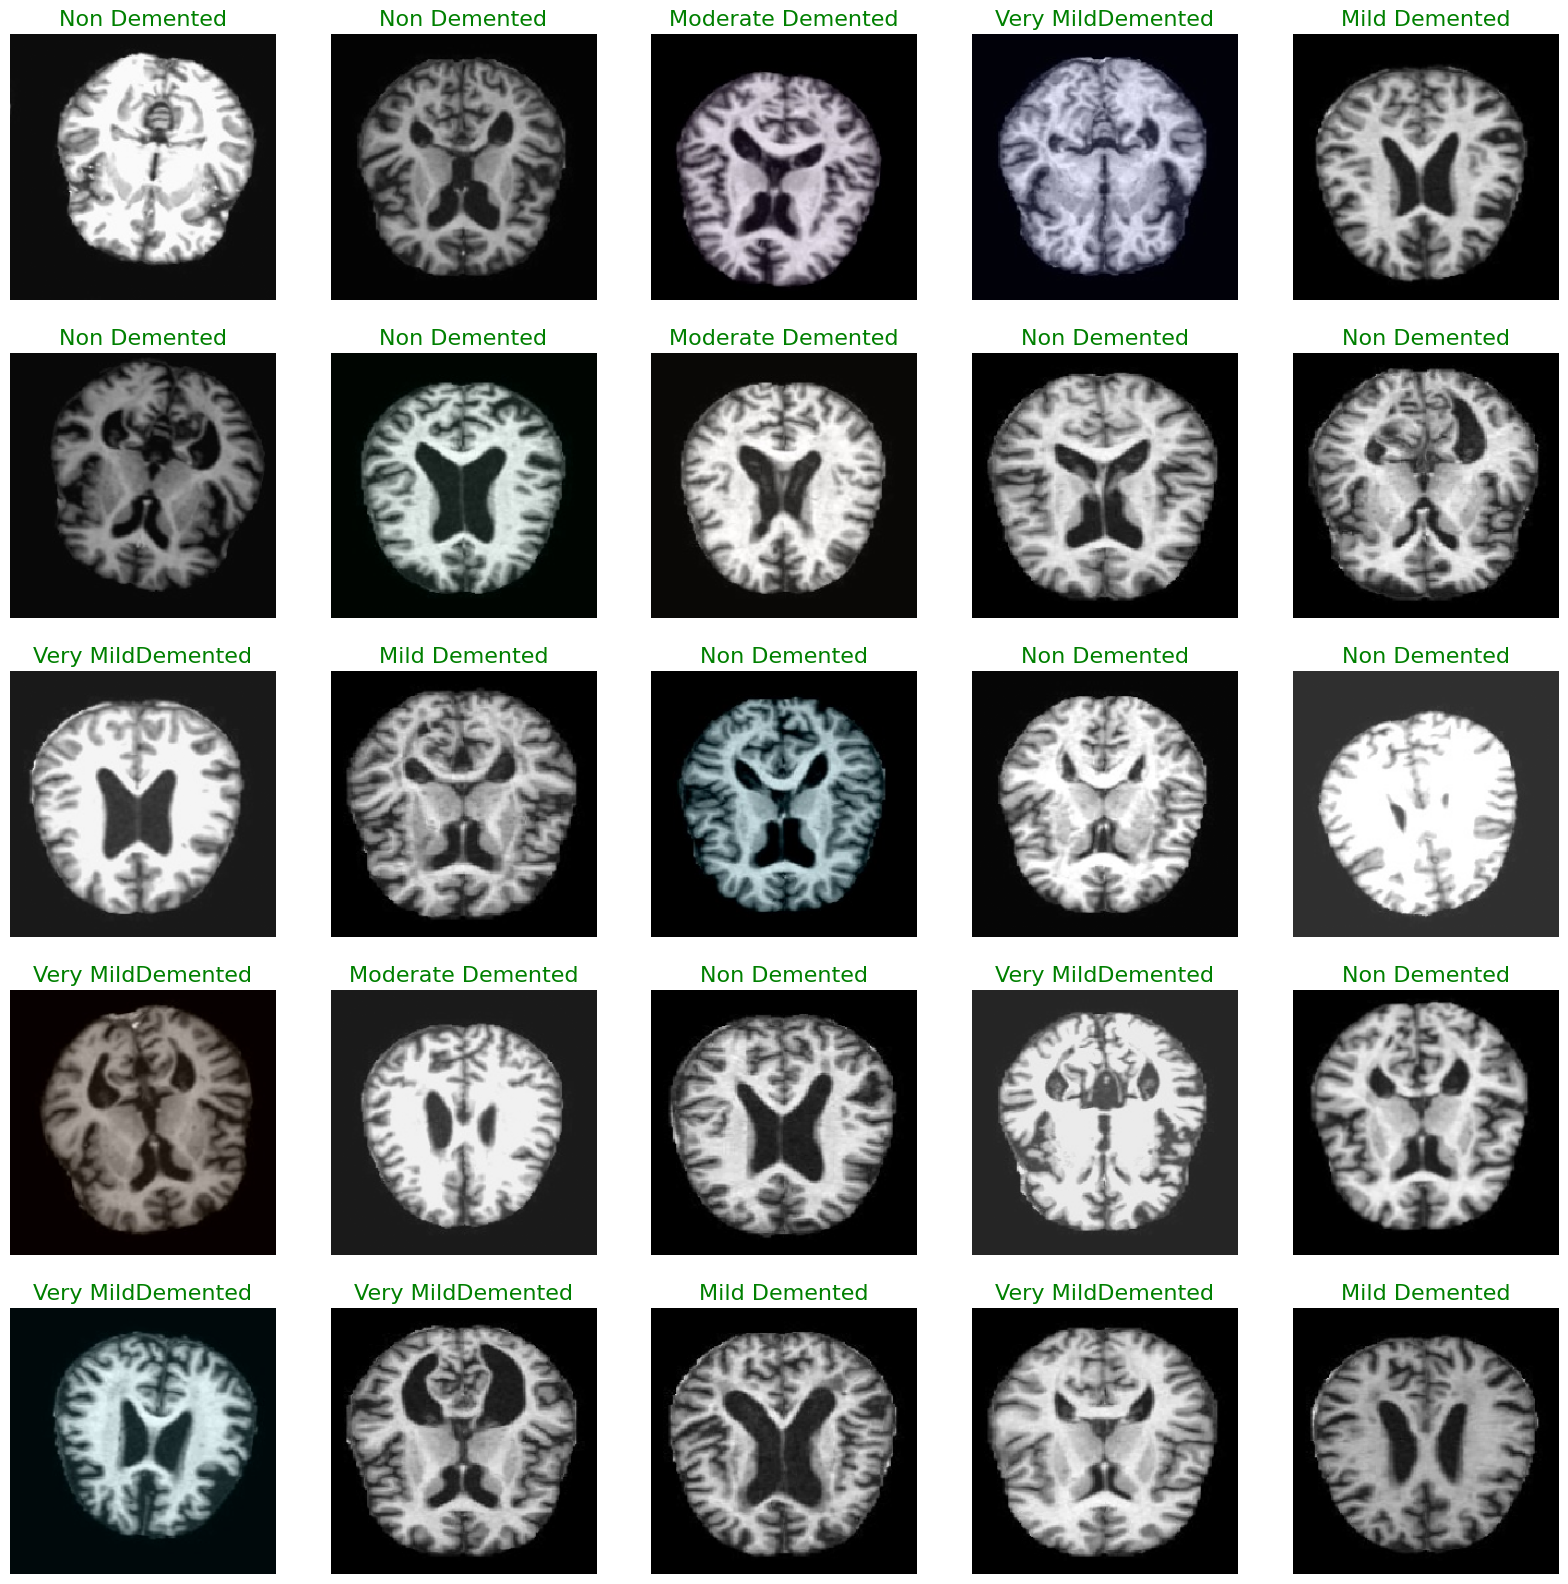

In [ ]:
show_knee_images(train)

In [ ]:
from tensorflow.keras.optimizers import Adamax

img_shape=(244,244,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet", #include_top false for not adding dense layer in xception that will be done by us manually
                            input_shape= img_shape, pooling= 'max')



In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block14_sepconv2':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Print out the layer names and whether they are trainable
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_layer_2 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d_4 False
block2_pool False
batch_normalization_4 False
add_12 False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_5 False
block3_pool False
batch_normalization_5 False
add_13 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_6 False
block4_pool False
batch_normalization_6 False
add_14 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepconv3_bn False

In [ ]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 121, 121,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 121, 121,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 121, 121,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 119, 119,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 119, 119,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 119, 119,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 119, 119,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 119, 119,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 119, 119,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 119, 119,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 119, 119,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 60, 60,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 60, 60,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 60, 60,    │          0 │ add_12[0][0]    

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 3,163,648 (12.07 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

In [ ]:
# for layer in base_model.layers:
#     layer.trainable = False

Xception_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

Xception_model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

Xception_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 3,426,436 (13.07 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

In [ ]:
history = Xception_model.fit(train, epochs=10, validation_data=val, validation_freq=1)

Epoch 1/10


I0000 00:00:1739362994.753212     134 service.cc:145] XLA service 0x789d000022f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739362994.753265     134 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/595 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.2188 - loss: 3.4122   

I0000 00:00:1739363004.800517     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


595/595 ━━━━━━━━━━━━━━━━━━━━ 149s 224ms/step - accuracy: 0.5292 - loss: 1.1558 - val_accuracy: 0.6786 - val_loss: 0.7032
Epoch 2/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.6803 - loss: 0.7039 - val_accuracy: 0.7350 - val_loss: 0.5912
Epoch 3/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.7339 - loss: 0.5939 - val_accuracy: 0.7768 - val_loss: 0.4987
Epoch 4/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.7901 - loss: 0.4919 - val_accuracy: 0.8003 - val_loss: 0.4536
Epoch 5/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.8258 - loss: 0.4142 - val_accuracy: 0.8377 - val_loss: 0.3953
Epoch 6/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - accuracy: 0.8611 - loss: 0.3376 - val_accuracy: 0.8642 - val_loss: 0.3403
Epoch 7/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - accuracy: 0.8891 - loss: 0.2821 - val_accuracy: 0.8691 - val_loss: 0.3226
Epoch 8/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - accuracy: 0.9121 - loss: 0.2260 - va

In [ ]:
train_loss, train_accuracy = Xception_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

595/595 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.9854 - loss: 0.0612

Train loss: 0.06
Train Accuracy: 98.55 %


In [ ]:
train_loss, train_accuracy = Xception_model.evaluate(val)
print(f'\nvalidation loss: {train_loss:.2f}')
print(f'Validation Accuracy: {train_accuracy*100:.2f} %')

149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.8975 - loss: 0.2788

validation loss: 0.28
Validation Accuracy: 89.37 %


In [ ]:
train_loss, train_accuracy = Xception_model.evaluate(test)
print(f'\ntest loss: {train_loss:.2f}')
print(f'test Accuracy: {train_accuracy*100:.2f} %')

319/319 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.8976 - loss: 0.2789

test loss: 0.28
test Accuracy: 89.70 %


In [ ]:
history1 = Xception_model.fit(train, epochs=1, validation_data=val, validation_freq=1)

595/595 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - accuracy: 0.9538 - loss: 0.1272 - val_accuracy: 0.8968 - val_loss: 0.2617


In [ ]:
Xception_model.evaluate(test, verbose=1)

319/319 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.8974 - loss: 0.2713


[0.26758894324302673, 0.9011377096176147]

In [ ]:
pred = Xception_model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

319/319 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step


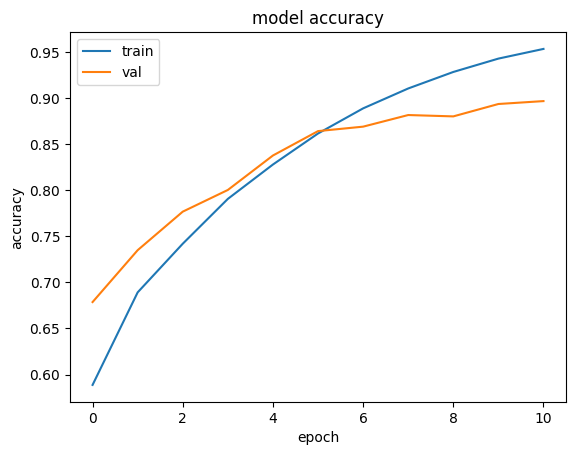

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

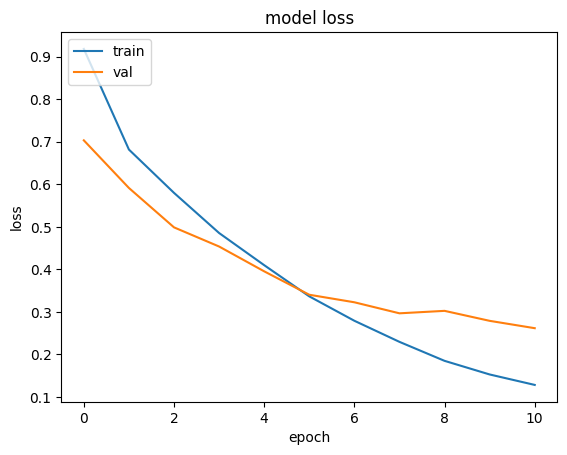

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                   precision    recall  f1-score   support

    Mild Demented       0.95      0.89      0.92      2688
Moderate Demented       0.99      1.00      0.99      1940
     Non Demented       0.89      0.86      0.87      2880
Very MildDemented       0.82      0.89      0.85      2688

         accuracy                           0.90     10196
        macro avg       0.91      0.91      0.91     10196
     weighted avg       0.90      0.90      0.90     10196

Accuracy of the Model: 90.1%


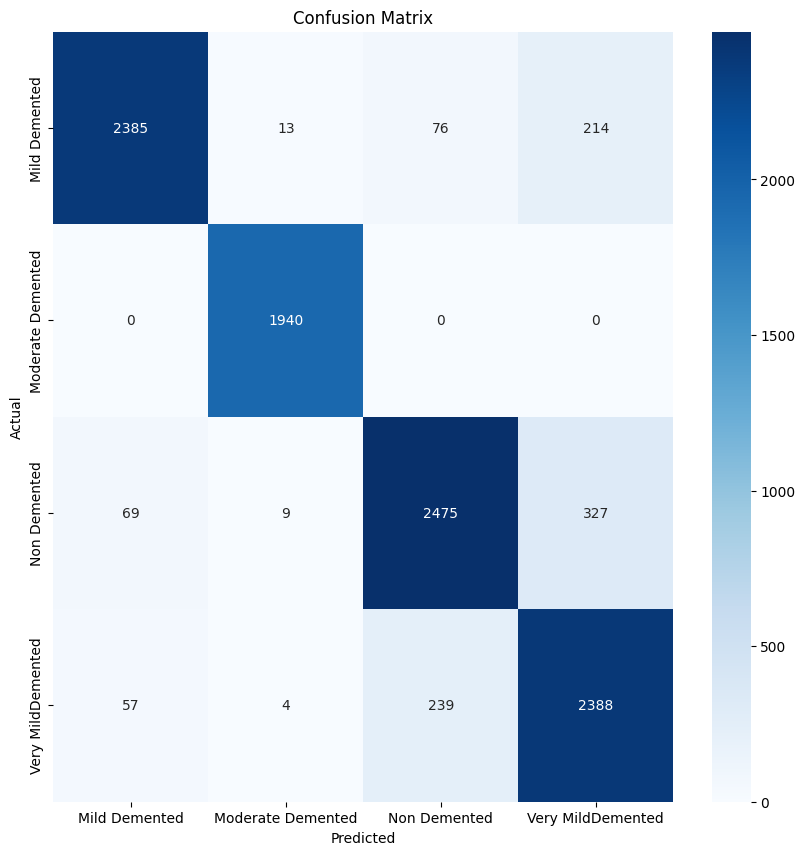

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [ ]:
# Save the trained model
Xception_model.save('Xception_alzheimer_model.h5')
print("Model saved successfully!")

Model saved successfully!
